# Unsupervised learning approach to refugee resettlement

In [251]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN

import altair as alt
import umap.umap_ as umap

In [252]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = (
    None  # default='warn', this removes warning on dropping columns
)

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # Warning for future states of used libraries
warnings.simplefilter(
    action="ignore", category=FutureWarning
)  # Warning for future states of used libraries
warnings.simplefilter(
    action="ignore", category=UserWarning
)  # Warning for known bug with plotting the barh graphs

In [253]:
# Utility functions


def add_info_to_reduced(reduced, original, labels=None):
    """Transformed reduced data into a dataframe and adds target info"""
    reduced = pd.DataFrame(reduced)
    reduced.columns = reduced.columns.astype(str)
    reduced["Target"] = list(original["t_resettlement"])

    # Add clustering labels
    if labels is not None:
        reduced["Cluster"] = list(labels)

    return reduced


def viz_reduction(source, params, label="Target", c_scheme="reds"):
    """Produces 2D chart of reduced data"""

    # Produce chart
    chart = (
        alt.Chart(source)
        .mark_circle()
        .encode(
            x=alt.X("0", title="Component 1"),
            y=alt.Y("1", title="Component 2"),
            color=alt.Color(label, scale=alt.Scale(scheme=c_scheme)),
        )
        .configure_axis(grid=False)
        .properties(
            title="Visualization of ASR data using {}, {}".format(
                params["method"], params["year"]
            ),
            width=500,
            height=500,
        )
    )

    return chart

## Data Import and Prep

In [254]:
# Read in the dataset prepared in Create_Target notebook
rsp_df = pd.read_csv("../Data/processed/dataset_2016-19_target")

In [255]:
# Drop constructed variables
columns_to_drop = [col for col in rsp_df.columns if col.startswith("ui_")]
rsp_df.drop(columns_to_drop, axis=1, inplace=True)

# Drop answers that are binaries for sub-questions in the survey.
# These are asked post resettlement so wont be used in main work of this notebook.
ma = [
    "qn17_01",
    "qn17_02",
    "qn17_03",
    "qn17_04",
    "qn17_05",
    "qn17_06",
    "qn17_07",
    "qn17_08",
    "qn17_97",
    "qn31f",
    "qn33f",
    "qn34f",
    "qn26ha_01",
    "qn26ha_02",
    "qn26ha_03",
    "qn26ha_04",
    "qn26ha_05",
    "qn26ha_06",
    "qn26ha_07",
    "qn26ha_08",
    "qn29a_97",
    "qn29a_02",
    "qn29a_03",
    "qn29a_04",
    "qn29a_05",
    "qn29a_06",
    "qn29a_07",
    "qn29a_08",
    "qn29a_09",
    "qn29a_10",
    "qn29a_11",
    "qn29a_12",
    "qn29a_97",
    "qn29d_01",
    "qn29d_02",
    "qn29d_03",
    "qn29d_04",
    "qn29d_97",
]
rsp_df.drop(ma, axis=1, inplace=True)

In [256]:
# Features known before resettling
pre_feats = [
    "numppl",
    "qn1c",
    "qn1d",
    "qn1f",
    "qn1g",
    "qn1h",
    "qn1i",
    "qn2a",
    "qn2b",
    "qn3a",
    "qn4a",
    "qn4c",
    "qn1k",
    "qn1jyear",
    "t_resettlement",
]

# Features of current life
post_feats = [
    "qn4b",
    "qn4e",
    "qn4j",
    "qn5a",
    "qn5b",
    "qn6a",
    "qn6b",
    "qn7",
    "qn8a",
    "qn9",
    "qn10a",
    "qn11a",
    "qn11aa",
    "qn12",
    "qn13",
    "qn18b",
    "qn18dyear",
    "qn18e",
    "qn19b",
    "qn20",
    "qn24a",
    "qn24b",
    "qn25a",
    "qn25b",
    "qn25c",
    "qn25d",
    "qn26b",
    "qn26d",
    "qn26estate",
    "qn26f",
    "qn26h",
    "qn27a",
    "qn27bmnth",
    "qn30a",
    "qn30d",
    "qn31a",
    "qn31d",
    "qn31e",
    "qn32a",
    "qn32d",
    "qn32e",
    "qn33a",
    "qn33d",
    "qn33e",
    "qn34a",
    "qn34d",
    "qn34e",
    "qn35a",
    "qn38a",
    "qn38b",
    "qn38c",
]

## Proactive resettlement analysis

In [257]:
# Select only features identified as available at time of resettlement.
pre_df = rsp_df[pre_feats]

# Apply binary/ordinal encoding where needed, and convert relevant columns to numeric.
pre_df["qn1f"].replace(["male", "female"], [0, 1], inplace=True)
pre_df["qn4c"].replace(["no", "yes"], [0, 1], inplace=True)
pre_df["qn4a"].replace(
    ["not at all", "not well", "very well", "well"], [0, 1, 2, 3], inplace=True
)

pre_df["qn1f"] = pd.to_numeric(pre_df["qn1f"])
pre_df["qn4c"] = pd.to_numeric(pre_df["qn4c"])
pre_df["qn4a"] = pd.to_numeric(pre_df["qn4a"])

# To get our classifiers to work, we can't have NaNs. Since there are only 59 NaNs in the dataset, we drop them.
pre_df.dropna(inplace=True)

In [258]:
pre_df.head()

,numppl,qn1c,qn1d,qn1f,qn1g,qn1h,qn1i,qn2a,qn2b,qn3a,qn4a,qn4c,qn1k,qn1jyear,t_resettlement
0,1.0,never married,38.0,0,somalia,somalia,other,5.0,none,not employed,1.0,0.0,south,2012.0,1
2,3.0,now married,36.0,1,iraq,iraq,other,20.0,university degree (other than medical),civil servant (civilian in local or national g...,3.0,0.0,west,2014.0,1
3,1.0,legally separated,36.0,1,iraq,iraq,arab,16.0,university degree (other than medical),not employed,2.0,0.0,west,2012.0,1
4,1.0,now married,32.0,0,somalia,somalia,other,3.0,other,employed (unspecified if private or government),3.0,1.0,west,2015.0,1
5,5.0,never married,27.0,1,iraq,iraq,arab,15.0,secondary (or high school diploma),student,3.0,0.0,west,2012.0,0


In [259]:
pre_df.drop("qn1g", axis=1, inplace=True)

y = pre_df["t_resettlement"]
X = pre_df.drop("t_resettlement", axis=1)

In [260]:
# Given the high cardinality of our categorical features, we opt to use a target encoder.
# A good explanation of this technique can be found here: https://maxhalford.github.io/blog/target-encoding/
encoder = ce.TargetEncoder(return_df=True)
X = encoder.fit_transform(X, y)

In [261]:
# In order to for our classifiers to work as intended and be comparable to one another, we apply an sklearn.StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Dimensionality Reduction

#### PCA

In [262]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Print stats
print("Number of PCs: {}".format(len(pca.explained_variance_ratio_)))
print("Explained variation per PC: {}".format(pca.explained_variance_ratio_))
print("Sum of explained variation: {}".format(pca.explained_variance_ratio_.sum()))
print("\n")

Number of PCs: 2
Explained variation per PC: [0.16544603 0.15595143]
Sum of explained variation: 0.32139746278366876




In [263]:
# Set params for viz
params = {}
params["dataset"] = "Annual Survey of Refugees"
params["year"] = "2016-19"
params["indicator"] = "t_resettlement"

# PCA visualization with two components
params["method"] = "PCA"
viz_reduction(add_info_to_reduced(X_pca, pre_df), params)

alt.Chart(...)

From what we can see, PCA does not seem suitable for this dataset in terms of visualization and dimensionality reduction. Instead, we will attempt to use UMAP instead.

#### UMAP

In [264]:
# Visually tuning hyperparameters for UMPA


def draw_umap_grid(
    data,
    n_neighbors_options,
    min_dist_options,
    n_components=2,
    metric="euclidean",
):
    """Visually explores different hyperparameters for UMAP"""

    # Create figure
    nrows = len(n_neighbors_options)
    ncols = len(min_dist_options)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

    # Handle special case
    if nrows == 1:
        axs = [axs]
    if ncols == 1:
        axs = [axs]

    # Iterate over all parameter combinations of n_neighbors and min_dist
    for i, n_neighbors in enumerate(n_neighbors_options):
        for j, min_dist in enumerate(min_dist_options):
            # Configure UMAP
            fit = umap.UMAP(
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=n_components,
                random_state=42,
                metric=metric,
            )

            # Plot
            u = fit.fit_transform(data)
            ax = axs[i][j]
            ax.scatter(u[:, 0], u[:, 1])
            ax.set_title(
                f"Neighbors: {n_neighbors}, Min Dist: {min_dist}",
                fontsize=10,
            )
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    # Adjust layout
    plt.tight_layout()
    plt.show()

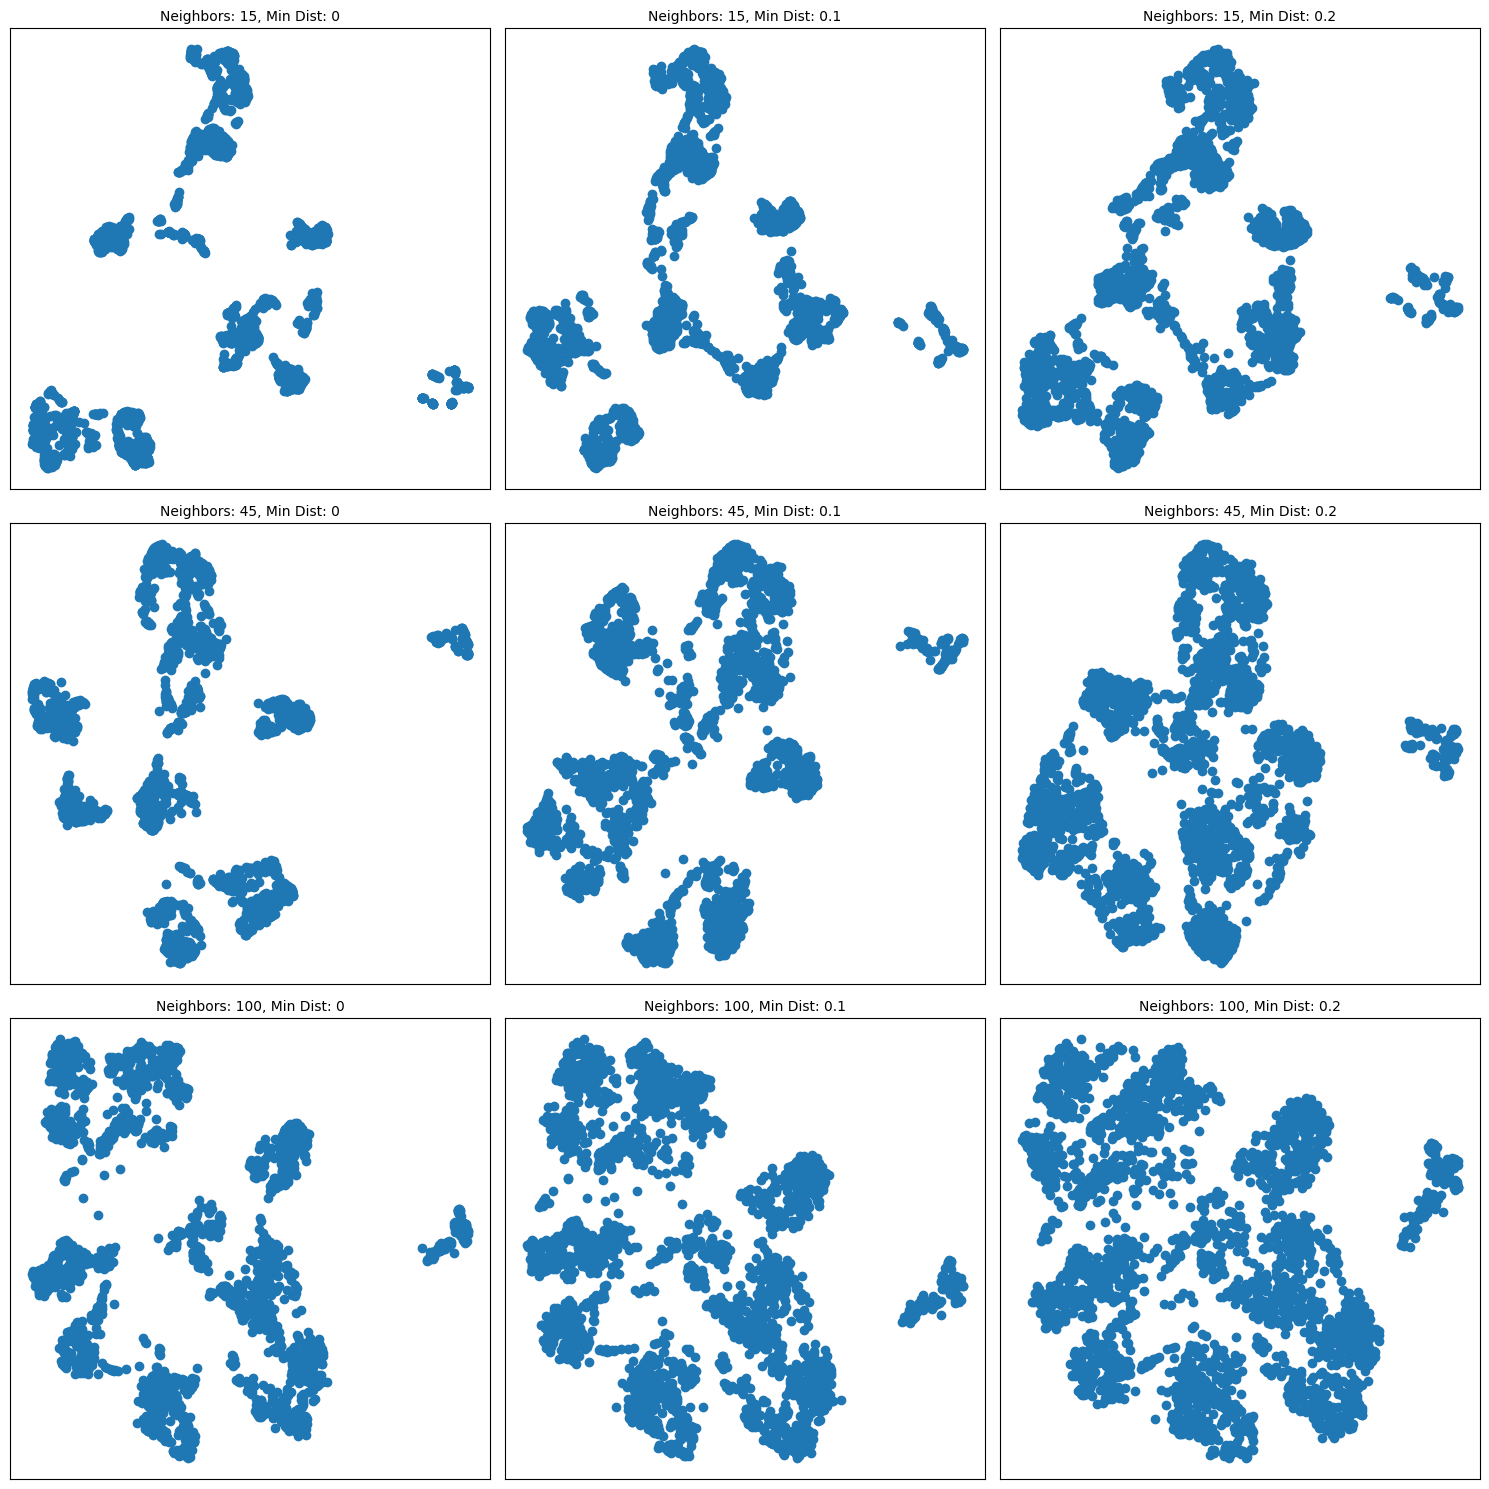

In [265]:
draw_umap_grid(X, (15, 45, 100), (0, 0.1, 0.2))

The hyparameters that we will use here are 45 for n_neighbors and 0 for min_dist, as these give us about 8 mostly-separated clusters.

In [266]:
# Final UMAP visualization
embeddings = umap.UMAP(
    n_components=2, n_neighbors=45, min_dist=0, random_state=42
).fit_transform(X)

params["method"] = "UMAP"
viz_reduction(add_info_to_reduced(embeddings, pre_df), params)

alt.Chart(...)

#### HDBSCAN Clustering

HDBSCAN is used here as it is not only well suited to complex cluster patterns, but it also has in-built outlier detection.

In [270]:
hdb = HDBSCAN(min_cluster_size=115)
hdb.fit(embeddings)

pre_df["cluster"] = hdb.labels_

In [271]:
# Visualize HDBSCAN Clustering results

params["method"] = "HDBSCAN"
viz_reduction(
    add_info_to_reduced(embeddings, pre_df, hdb.labels_),
    params,
    label="Cluster:N",
    c_scheme="category10",
)

alt.Chart(...)

##### Cluster Investigation

In [272]:
# Size and average success rate of each cluster
cluster_stats = pd.concat(
    [
        pre_df.groupby("cluster")["cluster"].count(),
        pre_df.groupby("cluster")["t_resettlement"].mean(),
    ],
    axis=1,
).sort_values(by="t_resettlement")

cluster_stats.rename(columns={"cluster": "count"}, inplace=True)

cluster_stats

,count,t_resettlement
cluster,,
0,176,0.431818
1,284,0.566901
3,498,0.610442
2,338,0.642012
7,931,0.718582
4,362,0.732044
6,323,0.795666
-1,81,0.814815
5,230,0.830435


In [273]:
# Mean values for all numeric qns in data
mean_numeric = (
    pre_df.select_dtypes(include=[np.number])
    .groupby("cluster")
    .mean()
    .drop("t_resettlement", axis=1)
)

pd.concat([mean_numeric, cluster_stats], axis=1).sort_values(by="t_resettlement")

,numppl,qn1d,qn1f,qn2a,qn4a,qn4c,qn1jyear,count,t_resettlement
cluster,,,,,,,,,
0,4.573864,41.346591,0.022727,8.147727,0.232955,0.142045,2016.079545,176,0.431818
1,3.883803,39.693662,0.000000,8.140845,0.595070,0.172535,2014.362676,284,0.566901
3,3.379518,36.989960,1.000000,9.166667,0.630522,0.002008,2014.997992,498,0.610442
2,3.269231,34.195266,1.000000,11.896450,1.286982,0.994083,2014.988166,338,0.642012
7,3.638024,41.343716,0.016112,10.673469,1.069817,0.009667,2014.244898,931,0.718582
4,3.314917,39.306630,0.000000,12.513812,1.541436,1.000000,2014.447514,362,0.732044
6,2.284830,31.244582,0.006192,11.665635,1.136223,0.000000,2014.554180,323,0.795666
-1,2.543210,34.012346,0.283951,11.135802,1.370370,0.135802,2013.938272,81,0.814815
5,2.452174,29.756522,0.008696,12.052174,1.573913,1.000000,2015.017391,230,0.830435


In [274]:
# Most common value for each categorical qn in data
mode_cat = (
    pd.concat([pre_df.select_dtypes(exclude=[np.number]), pre_df["cluster"]], axis=1)
    .groupby("cluster")
    .agg(pd.Series.mode)
)

pd.concat([mode_cat, cluster_stats], axis=1).sort_values(by="t_resettlement")

,qn1c,qn1h,qn1i,qn2b,qn3a,qn1k,count,t_resettlement
cluster,,,,,,,,
0,now married,syria,arab,primary,self-employed,midwest,176,0.431818
1,now married,iraq,arab,primary,self-employed,midwest,284,0.566901
3,now married,iraq,other,secondary (or high school diploma),not employed,south,498,0.610442
2,now married,other,other,secondary (or high school diploma),not employed,south,338,0.642012
7,now married,iraq,arab,secondary (or high school diploma),self-employed,midwest,931,0.718582
4,now married,iraq,other,secondary (or high school diploma),self-employed,south,362,0.732044
6,never married,iraq,other,secondary (or high school diploma),employee in private sector,west,323,0.795666
-1,never married,iraq,arab,secondary (or high school diploma),employee in private sector,west,81,0.814815
5,never married,iraq,other,secondary (or high school diploma),student,west,230,0.830435


Mean resettlement success rate was found to be in a large range, from 43% to 83%. At a glance, there appears to be a strong correlation between age, household size, education, and resettlement success. The most successful group on average were young refugees with small or no households who were students before arriving in the US. These people almost universally had prior English language training. The least successful group were the oldest, tended to have the largest households, and the least years of education.